# Zion Data Analysis Notebook

Defs, Imports, etc

In [1]:
import os, sys
from glob import glob
import time
from collections import UserDict, UserString
import numpy as np
import pandas as pd
from skimage.color import rgb2hsv
from skimage import filters, morphology, segmentation, measure
from scipy.optimize import nnls
from tifffile import imread, imwrite
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [11, 8]

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))
    

from ImageProcessing.ZionImage import ZionImage, create_labeled_rois, get_wavelength_from_filename, get_cycle_from_filename, get_time_from_filename, get_imageset_from_cycle
from ImageProcessing.ZionBaseCaller import crosstalk_correct, display_signals, create_phase_correct_matrix, base_call, add_basecall_result_to_dataframe, project_color
from ImageProcessing.ZionData import df_cols, extract_spot_data, csv_to_data, add_basecall_result_to_dataframe

### Give the notebook a directory of tiffs to work in and some parameters:

In [71]:
#input_dir_path = "C:\\Users\\ZacharyAugenfeld\\Documents\\ZionData\\20221129_1610_TS_0024_5Cycles_95Q7"
#input_dir_path = "C:\\Users\\ZacharyAugenfeld\\Documents\\ZionData\\S0063"
input_dir_path = "Z:\\GoogleData\\InstrumentData\\MK27_02\\20230419_2037_S0079_0001\\raws2"

# This parameter determines whether temporal difference images are used
useDifferenceImage = False

# This is the name of the UV channel
uv_wl = "365"

# This determines what type of background subtraction is used
bgSubtract = False

useTiff = False

# This was used to help with file identification
#bTiff = False


## Step 1: Spot Detection

### Define parameters used in spot detection. 

When you run this cell, ROIs will be displayed. Verify you get the spots you want. (If not, adjust parameters here and re-run.)

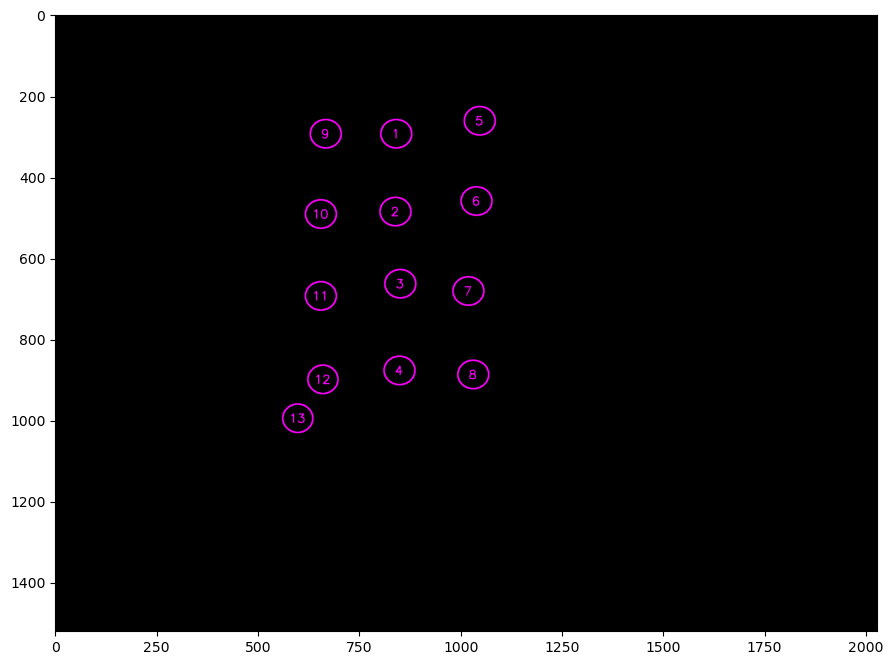

In [97]:
# This determines size of noise filter kernel (prob doesn't need to be changed much)
median_kernel_size = 9

# These tune spot size and how much spot border is included
erode_kernel_size = 30
dilate_kernel_size = 30

# This adjusts sensitivity for thresholding (should be close to 1)
threshold_scale = 0.9

# These are constraints on how large or small a spot could be
spotMinSize = 1200
spotMaxSize = None

# This is a list of RGB weights when turning the (UV) image to grayscale
rgb_weights = (0.4, 0.2, 0.1)
#rgb_weights = None

'''If roi_label_imagefile is set to None, spot detection will be performed.
   If it is set to a file, it will load spot ROIs and NOT run spot detection,
   and the above spot detection parameters will be ignored.'''

#roi_label_imagefile = None
roi_label_imagefile = "Z:\\GoogleData\\InstrumentData\\MK27_02\\20230419_2037_S0079_0001\\analysis\\jupyter\\RoiMap2.tif" #useful if already run



#### DO NOT EDIT BELOW THIS LINE ####
cycle1ImageSet = get_imageset_from_cycle(1, input_dir_path, uv_wl, useDifferenceImage, useTiff=useTiff)

if roi_label_imagefile is not None:
    spot_labels = imread(os.path.join(input_dir_path, roi_label_imagefile))
else:
    _,spot_labels,_ = cycle1ImageSet.detect_rois( os.path.join(input_dir_path), median_ks=median_kernel_size, erode_ks=erode_kernel_size, dilate_ks=dilate_kernel_size, threshold_scale=threshold_scale, minSize=spotMinSize, maxSize=spotMaxSize, gray_weights=rgb_weights)

rois_img = create_labeled_rois(spot_labels, notebook=True)
#imwrite(os.path.join(input_dir_path, "rois_img.tif"), rois_img)
plt.imshow(rois_img)

#TODO fix other excitation images with ROI overlay (works on pi so condition off of notebook=True)

Now you can remove spots by listing their labels in list of exclusions below, or add spots by attaching a label image (eg an ROI map tif file from ImageJ).

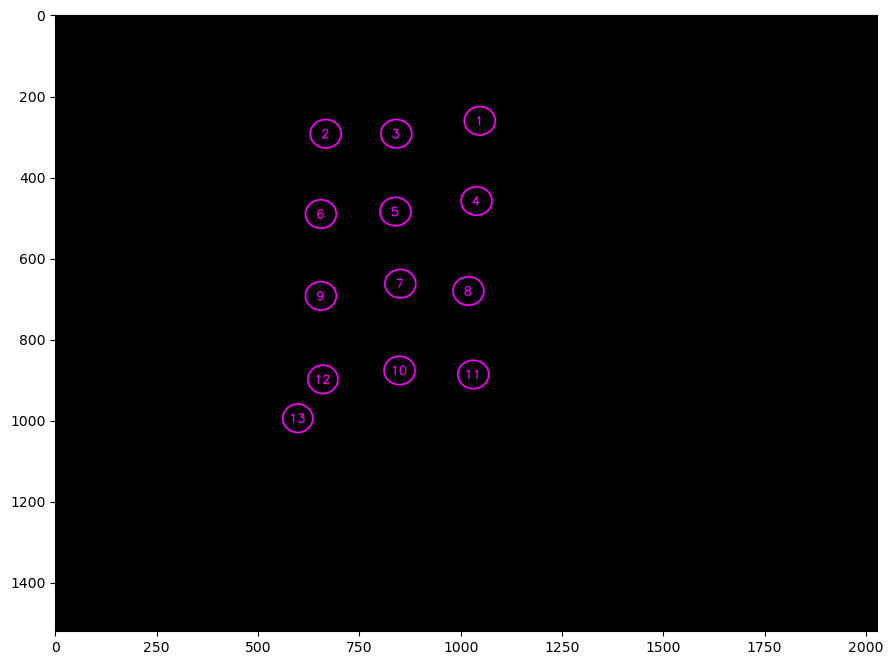

In [98]:
#exclusions = [5,16,19,24,46,55,63,68] #FAM dye fiducials - omit?

new_order = range(1,14)
#    1,2,3,
#    9,7,5,8,6,4,
#    19,14,18,15,11,17,16,12,13,10,
#    27,28,23,24,22,25,21,26,20,
#    33,37,34,36,29,35,32,30,31,
#    39,44,41,42,40,43,38,
#    53,45,54,52,46,50,49,47,51,48,
#    60,61,62,58,57,59,55,56,63,
#    67,71,70,65,69,66,68,64,
#    78,72,76,74,77,75,73,
#    80,79,82,81
#]

#new_order =[ 9, 8, 7, 6,   5,    4, 3, 2, 1,
#            18,17,13,14,  16,   15,12,11,10,
#            23,22,21,20,  19,
#            32,31,28,27,  24,   29,30,26,25,
#            40,39,38,36,        37,35,33,34,
#                                44,43,42,41,
#            51,52,50,53,        48,49,47,45,  46,
#            60,57,61,62,        59,58,56,54,  55,
#            64,65,67,66,                      63,
#            75,71,72,76,        73,74,69,70,  68,
#            82,80,83,84,        79,81,78,77
#           ]

label_image_to_fuse = None
#label_image_to_fuse = "Roi Map.tif"

#### DO NOT EDIT BELOW THIS LINE ####
binary_img1 = spot_labels.astype(bool)
binary_img2 = imread(os.path.join(input_dir_path, label_image_to_fuse)).astype(bool) if label_image_to_fuse is not None else np.zeros_like(binary_img1)

spot_labels2 = measure.label(np.logical_or(binary_img1, binary_img2))
spot_labels3 = np.zeros_like(spot_labels2)
for spot_label in new_order:
    spot_labels3[spot_labels2==spot_label]=new_order.index(spot_label)+1

rois_img = create_labeled_rois(spot_labels3, notebook=True)
imwrite(os.path.join(input_dir_path, "rois_img.tif"), rois_img)
plt.imshow(rois_img)
spot_labels = spot_labels3
imwrite(os.path.join(input_dir_path,"roi_labels.tiff"), spot_labels)

## Step 2: Define color dictionary

Either provide a file OR select spot (by label) for each base:

In [99]:
# For each base, provide purest spot (by label in image above): 
color_A_spots = [4]
color_C_spots = [5]
color_G_spots = [1]
color_T_spots = [8]

'''If basis_colors_file is set to None, spot detection will be performed.
   If it is set to a file, it will load color dictionary from file,
   ignoring the above basis color spots.'''

basis_colors_file = None
#basis_colors_file = os.path.join(input_dir_path, "M.npy")

# Define what spot is used as background/reference spot
# Note that this is only used if bgSubtract above is True
bg_spot = None

#### DO NOT EDIT BELOW THIS LINE ####
if basis_colors_file is not None:
    M = np.load(basis_colors_file)
else:
    M = np.zeros(shape=(3*(cycle1ImageSet.nChannels), 4))
    nSpots = np.max(spot_labels) # assumes we've already reindexed
    for base_spot_ind, base_spotlist in enumerate( (color_A_spots, color_C_spots, color_G_spots, color_T_spots) ):
        vec_list = []
        for base_spot in base_spotlist:
            vec_list.append( cycle1ImageSet.get_mean_spot_vector(spot_labels==base_spot) )
        #TODO: should we normalize the vector here?
        vec = np.mean(np.array(vec_list), axis=0)
        M[:,base_spot_ind] = vec
    np.save(os.path.join(input_dir_path, "M.npy"), M)
print(f"M = \n{M}")

M = 
[[ 3034.40687679  1460.21776504  1004.17191977  1363.73256925]
 [ 1289.64660936  2674.39159503  3861.53963706   730.65902579]
 [ 5534.61318052  4825.11938873   767.96943649  8474.63992359]
 [ 1341.08118434  1126.41069723  1505.71919771  1238.95319962]
 [  698.55205349  1220.34574976  7711.26838586   526.62082139]
 [12008.81375358 11890.04775549  1477.65807068 18167.05635148]
 [11859.56829035  9334.60553964  4259.1938873   1693.19961796]
 [11508.25023878 25002.59025788 24543.16905444  5135.30850048]
 [ 2602.18911175  3506.15090735  4987.44221585  1122.9608405 ]
 [18579.45367717  3821.70009551  4135.79751671  7122.04775549]
 [ 7120.69723018  2452.88443171  2463.63896848  2888.94364852]
 [ 1606.53295129  4105.42502388  4765.24164279   852.86341929]
 [ 7982.88825215  3642.18911175  3914.10506208  8977.78032474]
 [ 2512.22922636  1046.35148042  1096.16618911  2877.10410697]
 [  899.07545368  5405.5052531   4973.74594078   985.70773639]]


## Step 3: Extract spot data and write to CSV

In [100]:
numCycles = 5

csvfile = os.path.join(input_dir_path, "basecaller_spot_data.csv")
with open(csvfile, "w") as f:
    f.write(','.join(df_cols)+'\n')
    
for new_cycle in range(1,numCycles+1):
    currImageSet = get_imageset_from_cycle(new_cycle, input_dir_path, uv_wl, useDifferenceImage, useTiff=useTiff)
    print(currImageSet.cycle)
    spot_data = extract_spot_data(currImageSet, spot_labels, csvFileName=csvfile)

#needed to spoof 6 cycles collected for analysis
new_cycle = numCycles+1
currImageSet = get_imageset_from_cycle(new_cycle-1, input_dir_path, uv_wl, useDifferenceImage, useTiff=useTiff)
currImageSet.cycle = new_cycle
print(currImageSet.cycle)
spot_data = extract_spot_data(currImageSet, spot_labels, csvFileName=csvfile)
numCycles += 1


1
2
3
4
5
6


## Step 4: Perform base-calling

### First, determine signal pre-phase-correction:
Define number of cycles COLLECTED (phase-corrected output of base-caller will be 1 fewer):

In [101]:
#### DO NOT EDIT BELOW THIS LINE ####
# todo kinetics figure, similar to below
# generate pre-phase-correction histograms:
basecall_csv = csvfile

#todo: add option to use median instead of mean

basecall_pd = csv_to_data(basecall_csv)
basecall_data = basecall_pd.to_numpy()
signal_pre_basecall, spotlist, basecall_pd_pre = crosstalk_correct(basecall_pd, M, numCycles, cycle1ImageSet.wavelengths, factor_method="nnls")

#spotlist = sorted(spotlist)
basecall_pd_pre.to_csv(os.path.join(input_dir_path, "basecaller_output_data_pre.csv"))
#print(spotlist)

### Next, define p and q for phase correction matrix:

In [102]:
p = 0.015   # Probability that ZERO new base synthesized during a cycle (lagging)
q = 0.127   # Probability that TWO new bases synthesized during a cycle (leading)

#### DO NOT EDIT BELOW THIS LINE ####
Qinv = create_phase_correct_matrix(p,q,numCycles)
signal_post_basecall = np.transpose( (np.transpose(signal_pre_basecall, axes=(0,2,1)) @ Qinv)[:,:,:-1], axes=(0,2,1))
basecall_pd_post = add_basecall_result_to_dataframe(signal_post_basecall, basecall_pd)
basecall_pd_post.to_csv(os.path.join(input_dir_path, "basecaller_output_data_post.csv"))


### Now display results and write to report
Define report filename and number of rows in figure outputs.

spotlist=['spot_001', 'spot_002', 'spot_003', 'spot_004', 'spot_005', 'spot_006', 'spot_007', 'spot_008', 'spot_009', 'spot_010', 'spot_011', 'spot_012', 'spot_013']
spotlist_to_show = ['spot_001', 'spot_002', 'spot_003', 'spot_004', 'spot_005', 'spot_006', 'spot_007', 'spot_008', 'spot_009', 'spot_010', 'spot_011', 'spot_012', 'spot_013']
page = 0, s_idx = 0
page = 0, s_idx = 1
page = 0, s_idx = 2
page = 0, s_idx = 3
page = 0, s_idx = 4
page = 0, s_idx = 5
page = 0, s_idx = 6
page = 0, s_idx = 7
page = 0, s_idx = 8
page = 0, s_idx = 9
page = 0, s_idx = 10
page = 0, s_idx = 11
page = 0, s_idx = 12
page = 0, s_idx = 0
page = 0, s_idx = 1
page = 0, s_idx = 2
page = 0, s_idx = 3
page = 0, s_idx = 4
page = 0, s_idx = 5
page = 0, s_idx = 6
page = 0, s_idx = 7
page = 0, s_idx = 8
page = 0, s_idx = 9
page = 0, s_idx = 10
page = 0, s_idx = 11
page = 0, s_idx = 12


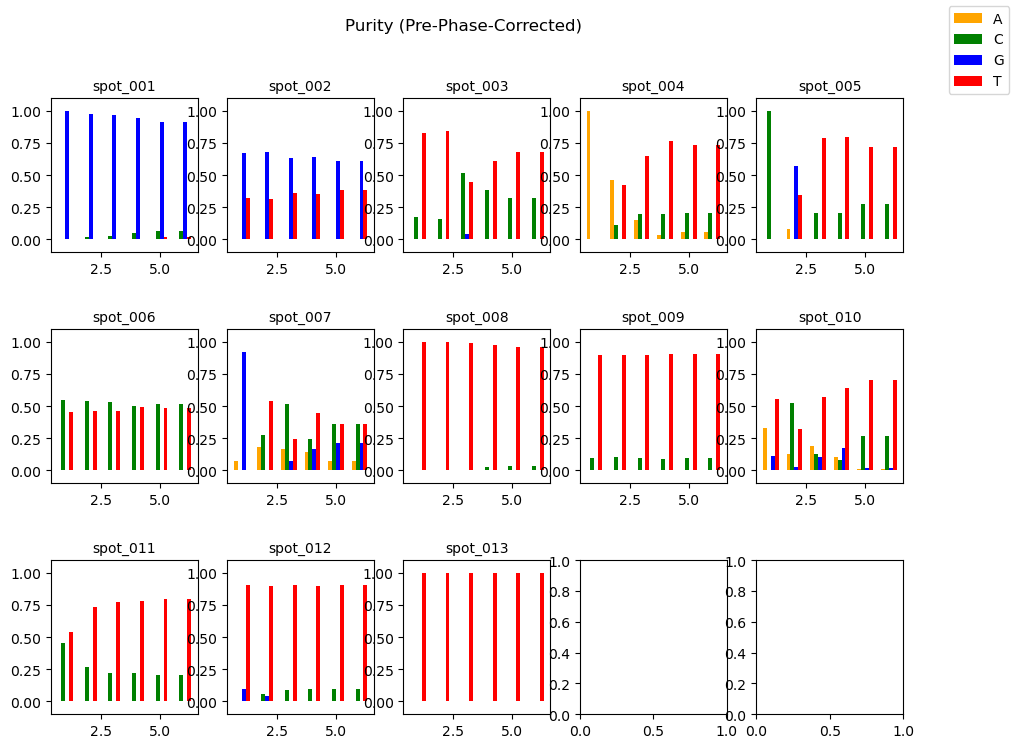

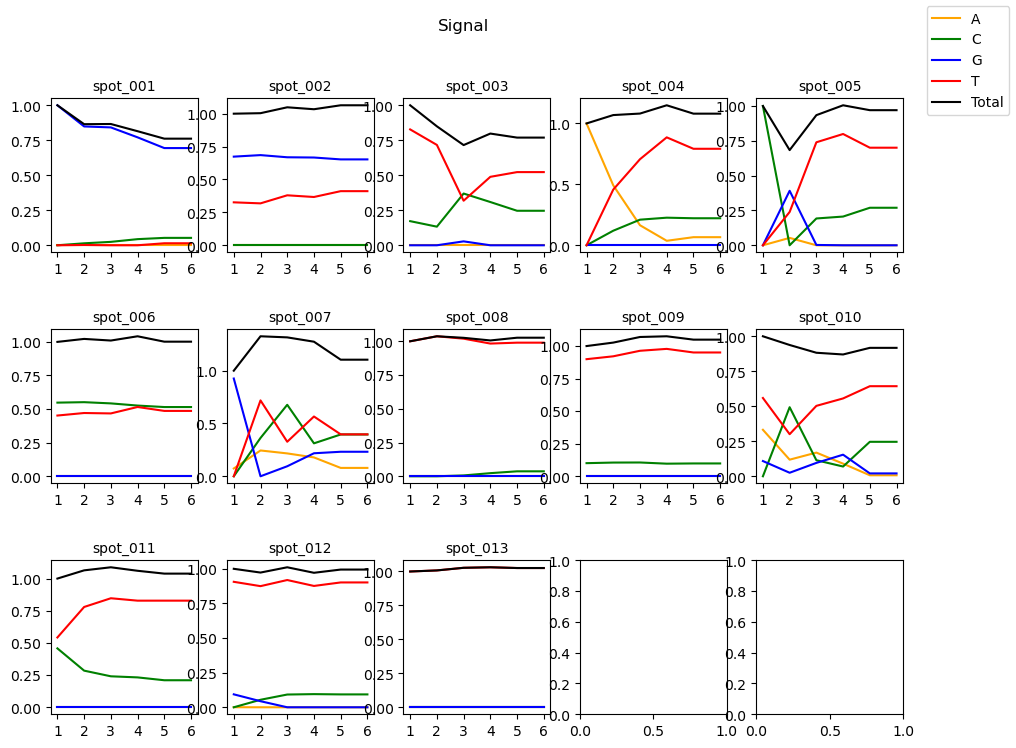

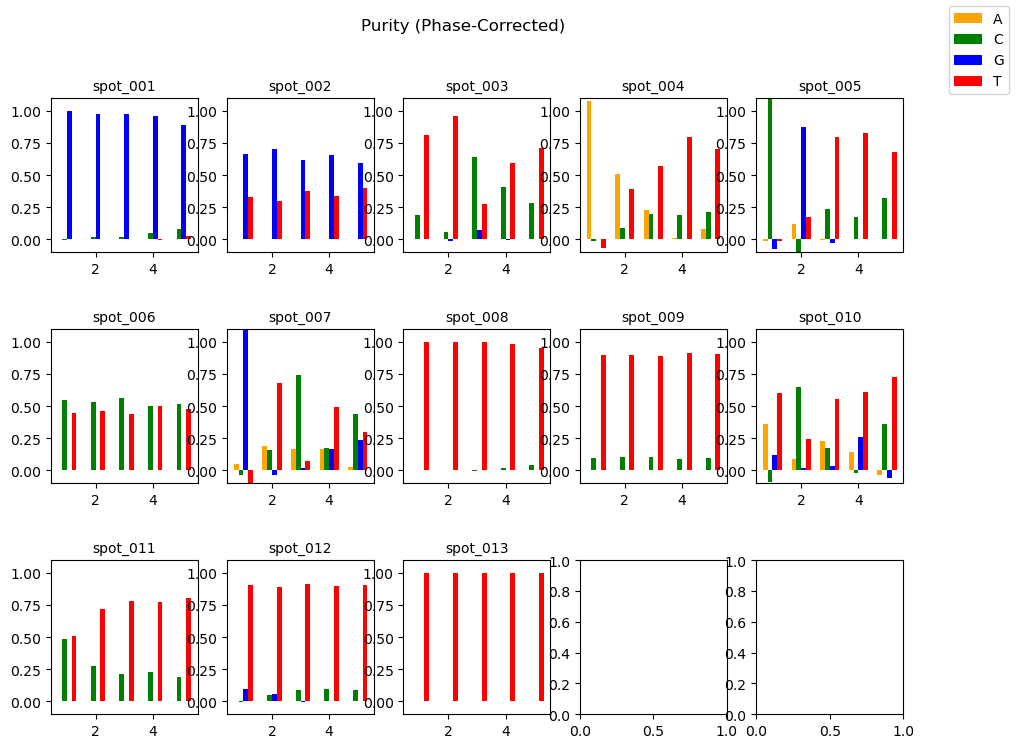

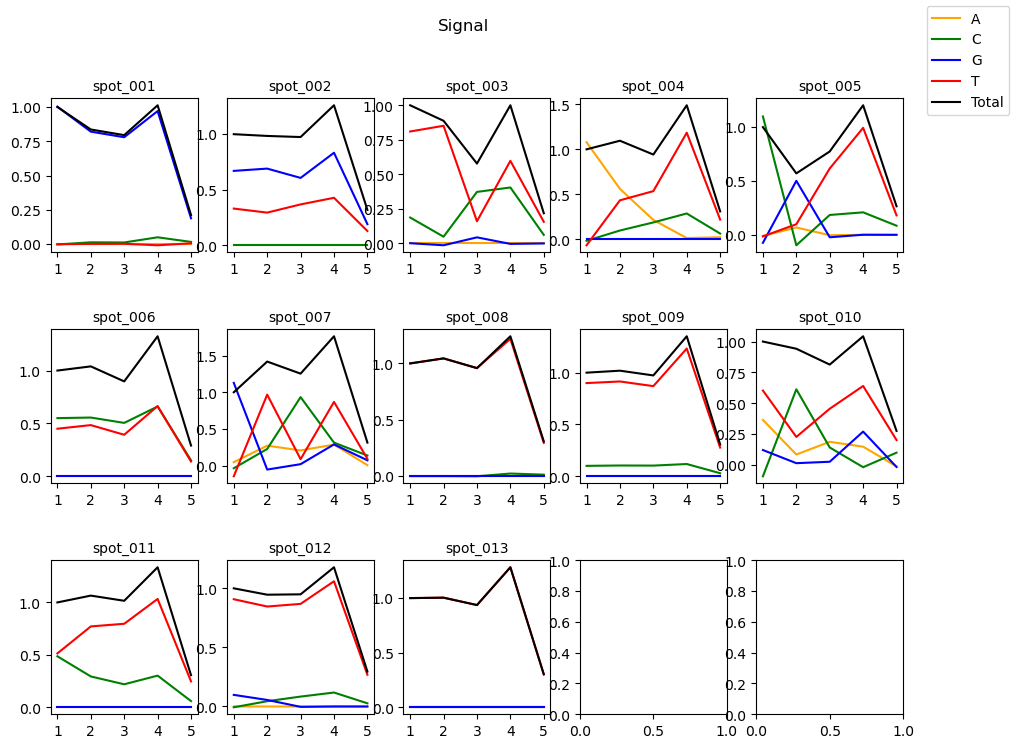

In [103]:
#Quadrant 1:
#spots_to_show = \
#[45,46,47,48,
# 54,55,56,57,
# 63,64,65,66,
# 68,69,70,71,
# 77,78,79,80,
#]

#exc = [1,2,3,4,10,17,20,21,22,23,25,30,32,34,39,46,63,68,70,71,72,74,76,77,78,81,82,
#      19,28,37,44,53,61,54,62,]
#spots_to_show =[5,11,12,15,29,42,67,80]
spots_to_show = list(range(1,14))

# You can name report file here:
reportfile = os.path.join(input_dir_path, "report.txt")

figNumRows = 3
figNumPages = 1

#TODO: spot name lookup table
#spotlist_to_show = []
#for s in range(1,83):
#    if s not in exc:
#        spotlist_to_show.append(spotlist[s-1])
spotlist_to_show = [spotlist[s-1] for s in spots_to_show]
print(f"spotlist={spotlist}")
print(f"spotlist_to_show = {spotlist_to_show}")

#### DO NOT EDIT BELOW THIS LINE ####
f1, f2 = display_signals(signal_pre_basecall, spotlist, numCycles, show_spots = spotlist_to_show, numRows=figNumRows, numPages=figNumPages, preOrPost="pre", labels=False)
f3, f4 = display_signals(signal_post_basecall, spotlist, numCycles-1, show_spots = spotlist_to_show, numRows=figNumRows, numPages=figNumPages, preOrPost="post", labels=False)

for f_idx, f in enumerate(f1):
    f.savefig(os.path.join(input_dir_path, f"Purity Pre-Phase {f_idx+1}.png"), dpi=300)
for f_idx, f in enumerate(f2):
    f.savefig(os.path.join(input_dir_path, f"Signal Pre-Phase {f_idx+1}.png"), dpi=300)
for f_idx, f in enumerate(f3):
    f.savefig(os.path.join(input_dir_path, f"Purity Post-Phase {f_idx+1}.png"), dpi=300)
#for f_idx, f in enumerate(f4):
#    f.savefig(os.path.join(input_dir_path, f"Signal Post-Phase {f_idx+1}.png"), dpi=300)

#TODO add more metrics to report
#TODO package up as pdf?    

with open(reportfile, 'w') as f:
    if useDifferenceImage:
        print(f"Difference = Temporal", file=f)
    else:
        print(f"Difference = Dark", file=f)

    print(f"Median Filter Kernel Size = {median_kernel_size}", file=f)
    print(f"Erosion Kernel Size = {erode_kernel_size}", file=f)
    print(f"Dilation Kernel Size = {dilate_kernel_size}", file=f)
    print(f"Mean Threshold Scale Factor = {threshold_scale}", file=f)
    print(f"ROI labels at {os.path.join(input_dir_path, 'rois.jpg')}", file=f)
    print(f"'Cross-talk' matrix M = {M}", file=f)
    #todo list where output csv is?
    print(f"Pre-phase corrected Purity at {os.path.join(input_dir_path, 'Purity Pre-Phase.png')}", file=f)
    print(f"Pre-phase corrected Signal {os.path.join(input_dir_path, 'Signal Pre-Phase.png')}", file=f)
    print(f"Base-caller p = {p}", file=f)
    print(f"Base-caller q = {q}", file=f)
    print(f"Post-phase corrected Purity at {os.path.join(input_dir_path, 'Purity Post-Phase.png')}", file=f)
    print(f"Post-phase corrected Signal {os.path.join(input_dir_path, 'Signal Post-Phase.png')}", file=f)

In [84]:
print(spotlist)

['spot_001', 'spot_002', 'spot_003', 'spot_004', 'spot_005', 'spot_006', 'spot_007', 'spot_008', 'spot_009', 'spot_010', 'spot_011', 'spot_012', 'spot_013']
